In [1]:
# =======================================================================
# PROYEK MACHINE LEARNING: KLASIFIKASI GENRE SASTRA
# =======================================================================
# TUJUAN: Membuat model yang dapat memprediksi genre buku berdasarkan sinopsisnya.
#
# TAHAPAN:
# 1. Persiapan: Impor library.
# 2. Memuat Data: Baca dataset 'booksummaries.txt'.
# 3. Pra-pemrosesan & EDA:
#    3.1. Ekstraksi dan analisis genre.
#    3.2. Pembersihan teks sinopsis.
# 4. Feature Engineering: Konversi teks ke vektor numerik (TF-IDF).
# 5. Pemodelan: Latih model klasifikasi Multinomial Naive Bayes.
# 6. Evaluasi: Ukur performa model dengan metrik akurasi dan visualisasi.
# 7. Aplikasi: Gunakan model untuk memprediksi genre dari sinopsis baru.
# =======================================================================

In [42]:
# =======================================================================
# LANGKAH 1: PERSIAPAN (IMPORT LIBRARIES)
# =======================================================================
print("Langkah 1: Mengimpor library...")

# Untuk manipulasi dan analisis data
import pandas as pd
import numpy as np
import json

# Untuk pemrosesan bahasa alami (Natural Language Processing)
import re
import nltk
from nltk.corpus import stopwords

nltk.download('averaged_perceptron_tagger_eng')

# Untuk visualisasi data yang informatif
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk membangun dan mengevaluasi model machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB



# Mengatur gaya visualisasi agar lebih menarik
sns.set(style="whitegrid", palette="viridis", font_scale=1.1)

print("Library yang dibutuhkan berhasil di-import!\n")


Langkah 1: Mengimpor library...
Library yang dibutuhkan berhasil di-import!



[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [ ]:
# =======================================================================
# LANGKAH 2: MEMUAT DATA
# =======================================================================
print("Langkah 2: Memuat dataset...")

# Konfigurasi path file dan nama kolom
FILE_PATH = 'dataset/booksummaries.txt'
COLUMN_NAMES = ['id_wikipedia', 'id_freebase', 'judul_buku', 'penulis', 'tanggal_terbit', 'genre', 'sinopsis']

try:
    # Memuat dataset menggunakan pandas, dengan pemisah tab
    df = pd.read_csv(FILE_PATH, sep='\t', header=None, names=COLUMN_NAMES, quoting=3) # quoting=3 untuk menangani kutipan
    print(f"Dataset berhasil dimuat! Terdiri dari {len(df)} baris.")
    # Menampilkan 5 baris pertama untuk inspeksi awal
    # display(df.head())
except FileNotFoundError:
    print(f"ERROR: File '{FILE_PATH}' tidak ditemukan. Pastikan file berada di direktori yang sama.")
except Exception as e:
    print(f"Terjadi error saat memuat data: {e}")

Langkah 2: Memuat dataset...
Dataset berhasil dimuat! Terdiri dari 16559 baris.



Langkah 3.1: Membersihkan dan mengeksplorasi data genre...
Jumlah data setelah menghapus baris kosong: 12841
Jumlah data setelah mengekstrak genre utama: 12841

Distribusi 5 Genre Teratas yang akan digunakan:
genre_utama
Science Fiction          2551
Speculative fiction      1438
Children's literature    1152
Fiction                   943
Novel                     925
Name: count, dtype: int64

Total data yang akan digunakan untuk model: 7009 baris


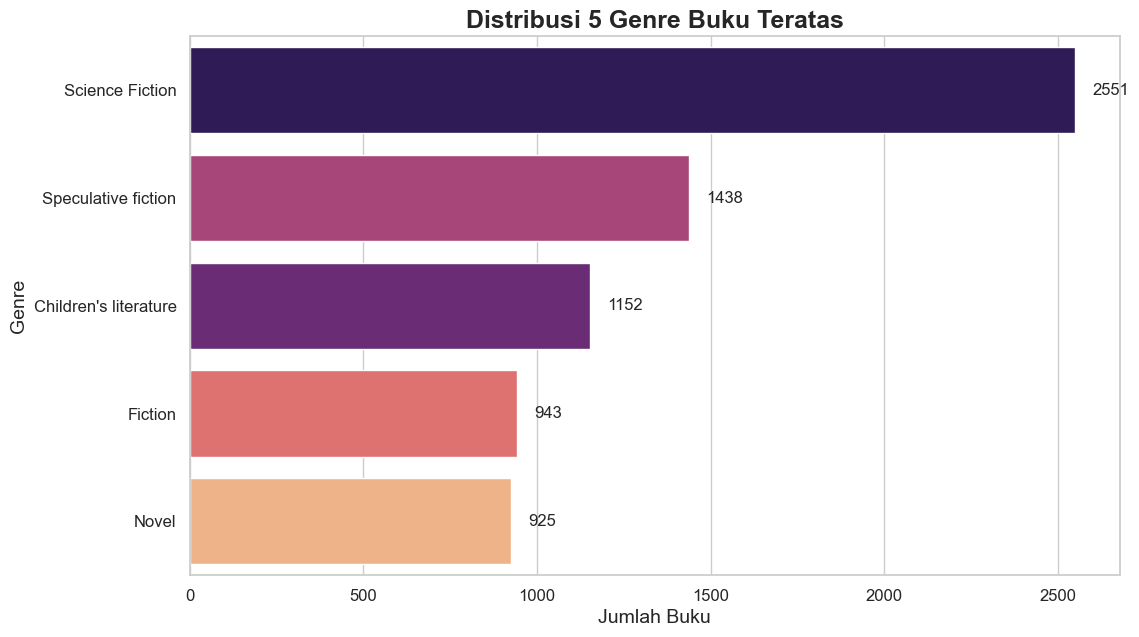

In [44]:
# =======================================================================
# LANGKAH 3.1: EKSPLORASI & PEMBERSIHAN DATA AWAL
# =======================================================================
print("\nLangkah 3.1: Membersihkan dan mengeksplorasi data genre...")

# 1. Pilih hanya kolom yang relevan untuk efisiensi memori
df_clean = df[['genre', 'sinopsis']].copy()

# 2. Hapus baris di mana 'genre' atau 'sinopsis' kosong (NaN)
df_clean.dropna(inplace=True)
print(f"Jumlah data setelah menghapus baris kosong: {len(df_clean)}")

# 3. Fungsi untuk mengekstrak genre utama dari format JSON yang kompleks
def extract_main_genre(genre_json):
    """Membaca string JSON, mengurai, dan mengembalikan genre pertama."""
    try:
        genres = json.loads(genre_json)
        # Ambil nilai (genre) pertama dari dictionary
        return list(genres.values())[0]
    except (json.JSONDecodeError, IndexError):
        # Kembalikan None jika format JSON tidak valid atau kosong
        return None

# Terapkan fungsi ke kolom 'genre' untuk membuat kolom 'genre_utama'
df_clean['genre_utama'] = df_clean['genre'].apply(extract_main_genre)

# Hapus baris di mana genre utama tidak berhasil diekstrak
df_clean.dropna(subset=['genre_utama'], inplace=True)
print(f"Jumlah data setelah mengekstrak genre utama: {len(df_clean)}")

# 4. Fokus pada 5 genre paling umum untuk menyederhanakan masalah klasifikasi
# Ini membantu model belajar lebih baik pada genre yang datanya cukup
top_5_genres = df_clean['genre_utama'].value_counts().nlargest(5).index.tolist()
df_final = df_clean[df_clean['genre_utama'].isin(top_5_genres)].copy()

print("\nDistribusi 5 Genre Teratas yang akan digunakan:")
print(df_final['genre_utama'].value_counts())
print(f"\nTotal data yang akan digunakan untuk model: {len(df_final)} baris")

# --- Visualisasi Distribusi Genre ---
plt.figure(figsize=(12, 7))

# KODE YANG DIPERBAIKI: Menambahkan 'hue' dan 'legend=False'
ax = sns.countplot(
    y='genre_utama',
    data=df_final,
    order=top_5_genres,
    palette='magma',
    hue='genre_utama',  # <-- Tambahkan parameter ini
    legend=False       # <-- Tambahkan parameter ini
)

plt.title('Distribusi 5 Genre Buku Teratas', fontsize=18, fontweight='bold')
plt.xlabel('Jumlah Buku', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Menambahkan label jumlah di setiap bar
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 50, p.get_y() + p.get_height() / 2,
             f'{int(width)}',
             va='center', fontsize=12)

plt.show()

In [45]:
# =======================================================================
# LANGKAH 3.2: PEMBERSIHAN TEKS (TEXT PREPROCESSING)
# =======================================================================
print("\nLangkah 3.2: Membersihkan teks sinopsis...")

# Unduh daftar stopwords dari NLTK (hanya perlu sekali)
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    print("Mengunduh paket 'stopwords' dari NLTK...")
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Fungsi untuk membersihkan teks:
    1. Mengubah ke huruf kecil.
    2. Menghapus karakter non-alfabet.
    3. Menghapus stopwords (kata-kata umum).
    """
    # 1. Ubah ke huruf kecil
    text = text.lower()
    # 2. Hapus semua karakter kecuali huruf a-z dan spasi
    text = re.sub(r'[^a-z\s]', '', text)
    # 3. Tokenisasi (memecah teks menjadi kata) dan hapus stopwords
    words = [word for word in text.split() if word not in stop_words]
    # Gabungkan kembali menjadi kalimat bersih
    return ' '.join(words)

# Terapkan fungsi pembersihan pada kolom sinopsis
df_final['sinopsis_bersih'] = df_final['sinopsis'].apply(clean_text)

print("Proses pembersihan teks selesai.")
# print("Contoh perbandingan sinopsis sebelum dan sesudah dibersihkan:")
# display(df_final[['sinopsis', 'sinopsis_bersih', 'genre_utama']].head())



Langkah 3.2: Membersihkan teks sinopsis...
Proses pembersihan teks selesai.


In [46]:
# =======================================================================
# LANGKAH 3.3: PEMBERSIHAN & LEMMATIZATION TEKS (VERSI OPTIMAL)
# =======================================================================
import nltk
import re
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords

print("\nLangkah 3.3: Membersihkan dan melakukan lemmatization pada teks sinopsis...")

# --- SETUP NLTK (Hanya dijalankan jika paket belum ada) ---
try:
    # Cek apakah paket-paket yang diperlukan sudah tersedia
    stop_words = set(stopwords.words('english'))
    nltk.data.find('corpora/wordnet')
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    # Jika belum, unduh semua yang diperlukan
    print("Mengunduh paket NLTK yang diperlukan (stopwords, wordnet, averaged_perceptron_tagger)...")
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    stop_words = set(stopwords.words('english'))

# --- Inisialisasi Lemmatizer & Fungsi Helper ---
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos_optimized(tag):
    """Fungsi helper untuk mengubah tag NLTK ke format yang diterima WordNetLemmatizer."""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_and_lemmatize_text(text):
    """
    Fungsi terpadu dan efisien untuk membersihkan dan melemmatisasi teks.
    """
    # Menangani input non-string (seperti NaN) untuk mencegah error
    if not isinstance(text, str):
        return ""

    # Pembersihan dasar
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = [word for word in text.split() if word not in stop_words]

    # Lemmatization yang dioptimalkan (POS tagging sekali per sinopsis)
    tagged_words = nltk.pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos_optimized(tag)) for word, tag in tagged_words]
    
    return ' '.join(lemmatized_words)

# --- Penerapan pada DataFrame ---
# Inisialisasi tqdm untuk menampilkan progress bar
tqdm.pandas(desc="Membersihkan Sinopsis")

# Terapkan fungsi pada kolom 'sinopsis' dan simpan ke 'sinopsis_bersih'
# .progress_apply() akan menampilkan bar kemajuan
df_final['sinopsis_bersih'] = df_final['sinopsis'].progress_apply(clean_and_lemmatize_text)

print("\nProses pembersihan dan lemmatization telah selesai.")
print("Contoh hasil:")
# Menampilkan 5 baris pertama untuk verifikasi
# display(df_final[['sinopsis', 'sinopsis_bersih']].head())


Langkah 3.3: Membersihkan dan melakukan lemmatization pada teks sinopsis...
Mengunduh paket NLTK yang diperlukan (stopwords, wordnet, averaged_perceptron_tagger)...


Membersihkan Sinopsis: 100%|██████████| 7009/7009 [01:21<00:00, 85.83it/s] 


Proses pembersihan dan lemmatization telah selesai.
Contoh hasil:


In [47]:
# =======================================================================
# LANGKAH 4: FEATURE ENGINEERING (TF-IDF VECTORIZATION)
# =======================================================================
print("\nLangkah 4: Mengubah teks menjadi fitur numerik (TF-IDF)...")

# Inisialisasi TF-IDF Vectorizer
# - max_features=5000: Hanya gunakan 5000 kata/frasa paling penting
# - ngram_range=(1,2): Pertimbangkan kata tunggal (unigram) dan frasa dua kata (bigram)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Definisikan fitur (X) dan target (y)
X = df_final['sinopsis_bersih']
y = df_final['genre_utama']

# Latih vectorizer dan transformasikan data teks menjadi matriks TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Bagi data menjadi 80% untuk pelatihan dan 20% untuk pengujian
# stratify=y memastikan proporsi genre di data latih dan uji sama
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.20, random_state=42, stratify=y)

print("Data berhasil diubah menjadi vektor dan dibagi.")
print(f"Dimensi data latih (X_train): {X_train.shape}")
print(f"Dimensi data uji (X_test): {X_test.shape}\n")


Langkah 4: Mengubah teks menjadi fitur numerik (TF-IDF)...
Data berhasil diubah menjadi vektor dan dibagi.
Dimensi data latih (X_train): (5607, 5000)
Dimensi data uji (X_test): (1402, 5000)



In [48]:
# =======================================================================
# LANGKAH 5 (DIPERBARUI): MELATIH & MEMBANDINGKAN BEBERAPA MODEL
# =======================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

print("Langkah 5: Melatih beberapa model klasifikasi...")

# Inisialisasi model-model yang akan diuji
models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Linear Support Vector Machine (SVC)": LinearSVC(random_state=42)
}

# Latih dan evaluasi setiap model
for name, model in models.items():
    print(f"\\n--- Melatih {name} ---")
    # Latih model
    model.fit(X_train, y_train)
    
    # Lakukan prediksi
    y_pred = model.predict(X_test)
    
    # Hitung akurasi
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Akurasi {name}: {accuracy * 100:.2f}%")

# Pilih model terbaik untuk evaluasi lebih lanjut di Langkah 6
# Berdasarkan hasil, Logistic Regression atau LinearSVC kemungkinan besar akan menjadi yang terbaik.
# Mari kita pilih salah satunya untuk digunakan di langkah selanjutnya.
best_model = models["Logistic Regression"] # Ganti jika model lain lebih baik
print("\\nModel terbaik tampaknya adalah Logistic Regression. Akan digunakan untuk evaluasi detail.")

Langkah 5: Melatih beberapa model klasifikasi...
\n--- Melatih Multinomial Naive Bayes ---
Akurasi Multinomial Naive Bayes: 58.42%
\n--- Melatih Logistic Regression ---
Akurasi Logistic Regression: 60.63%
\n--- Melatih Linear Support Vector Machine (SVC) ---
Akurasi Linear Support Vector Machine (SVC): 57.63%
\nModel terbaik tampaknya adalah Logistic Regression. Akan digunakan untuk evaluasi detail.


In [ ]:
# =======================================================================
# LANGKAH 5.1: PENYETELAN HIPERPARAMETER DENGAN GRIDSEARCHCV
# =======================================================================
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

print("\nLangkah 5.1: Mencari hiperparameter terbaik untuk model...")

# Kita akan menyetel Logistic Regression karena performanya bagus
# Kita membuat 'pipeline' untuk menyatukan vectorizer dan model.
# Ini penting agar GridSearchCV tidak mengalami kebocoran data (data leakage).

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

# Tentukan parameter yang ingin diuji
# 'tfidf__ngram_range': menguji unigram (1,1) vs unigram+bigram (1,2)
# 'tfidf__max_features': menguji jumlah kata penting yang berbeda
# 'clf__C': parameter regularisasi untuk Logistic Regression
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_features': [3000, 5000, 7000],
    'clf__C': [0.1, 1, 10],
}

# Inisialisasi GridSearchCV
# cv=3 berarti menggunakan 3-fold cross-validation
# n_jobs=-1 berarti menggunakan semua core CPU untuk mempercepat proses
grid_search = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, verbose=1)

# Latih grid search pada data teks mentah (bukan X_train yang sudah di-vectorize)
# Kita perlu membagi ulang data teks mentah
X_train_text, X_test_text, y_train_gs, y_test_gs = train_test_split(
    df_final['sinopsis_bersih'], 
    df_final['genre_utama'], 
    test_size=0.20, 
    random_state=42, 
    stratify=df_final['genre_utama']
)

print("Memulai Grid Search (proses ini mungkin memakan waktu beberapa menit)...")
grid_search.fit(X_train_text, y_train_gs)

print("\\nHasil Grid Search:")
print(f"Parameter terbaik: {grid_search.best_params_}")
print(f"Skor cross-validation terbaik: {grid_search.best_score_ * 100:.2f}%")

# Model terbaik sekarang adalah grid_search.best_estimator_
best_model_tuned = grid_search.best_estimator_

# Evaluasi model yang sudah disetel ini pada data uji
y_pred_tuned = best_model_tuned.predict(X_test_text)
accuracy_tuned = accuracy_score(y_test_gs, y_pred_tuned)
print(f"\\nAkurasi pada data uji setelah tuning: {accuracy_tuned * 100:.2f}%")


Langkah 5.1: Mencari hiperparameter terbaik untuk model...
Memulai Grid Search (proses ini mungkin memakan waktu beberapa menit)...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


Langkah 6: Mengevaluasi performa model...
Akurasi Model: 57.63%

Laporan Klasifikasi Detail:
                       precision    recall  f1-score   support

      Science Fiction       0.59      0.60      0.60       230
  Speculative fiction       0.40      0.37      0.39       189
Children's literature       0.33      0.31      0.32       185
              Fiction       0.77      0.81      0.79       510
                Novel       0.46      0.45      0.46       288

             accuracy                           0.58      1402
            macro avg       0.51      0.51      0.51      1402
         weighted avg       0.57      0.58      0.57      1402



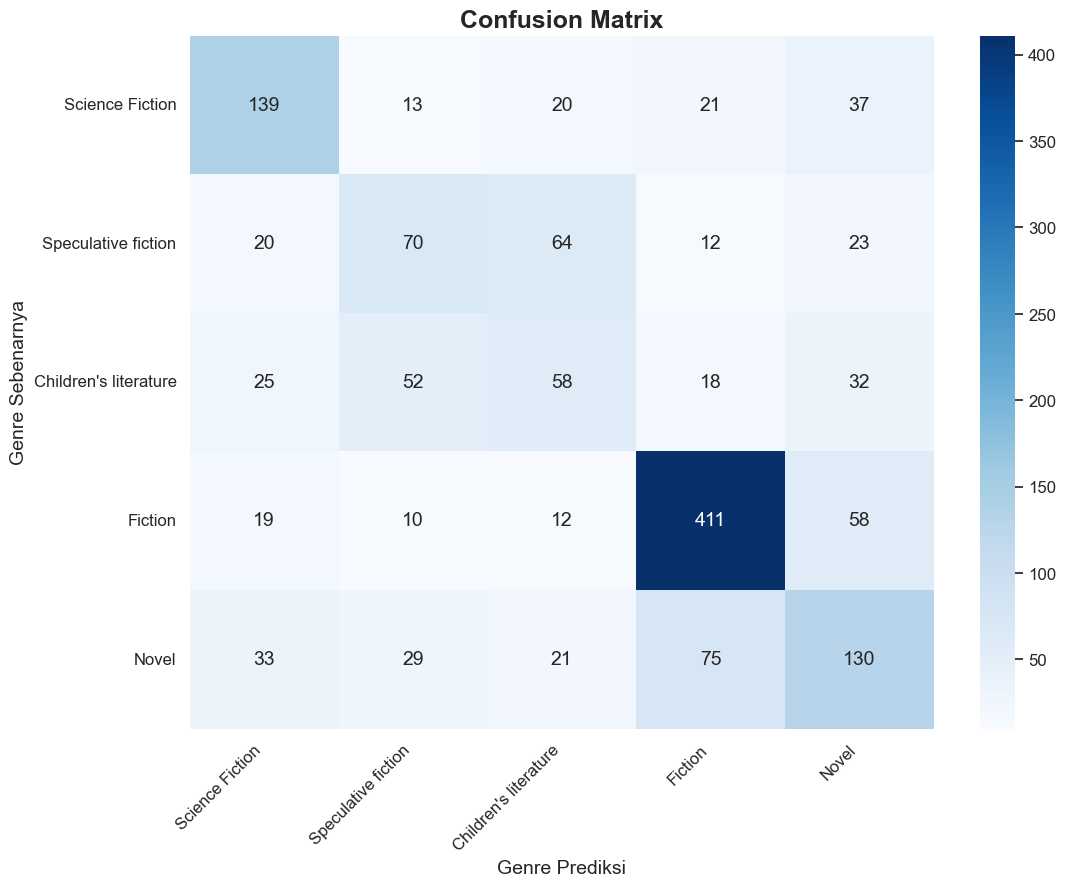

In [ ]:
# =======================================================================
# LANGKAH 6: EVALUASI MODEL
# =======================================================================
print("Langkah 6: Mengevaluasi performa model...")

# Lakukan prediksi pada data uji (data yang belum pernah dilihat model)
y_pred = model.predict(X_test)

# Hitung akurasi keseluruhan
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model: {accuracy * 100:.2f}%\n")

# Tampilkan laporan klasifikasi yang lebih detail (precision, recall, f1-score)
print("Laporan Klasifikasi Detail:")
print(classification_report(y_test, y_pred, target_names=top_5_genres))

# --- Visualisasi Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=top_5_genres, yticklabels=top_5_genres,
            annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=18, fontweight='bold')
plt.xlabel('Genre Prediksi', fontsize=14)
plt.ylabel('Genre Sebenarnya', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

In [ ]:
# =======================================================================
# LANGKAH 7: APLIKASI & PENGUJIAN LANGSUNG (VERSI FINAL)
# =======================================================================
from tabulate import tabulate
import pandas as pd # Pastikan pandas diimpor

print("\nLangkah 7: Melakukan prediksi pada sinopsis baru...")

def predict_genre_from_file(filepath, model_pipeline):
    """
    Membaca sinopsis dari file, membersihkannya, melakukan prediksi genre,
    dan menampilkan hasilnya dalam format tabel yang rapi.
    
    Args:
        filepath (str): Path ke file .txt yang berisi sinopsis.
        model_pipeline: Model scikit-learn yang sudah dilatih (bisa berupa Pipeline
                        dari GridSearchCV atau model individual).
    """
    try:
        # 1. Baca file sinopsis
        with open(filepath, 'r', encoding='utf-8') as file:
            sinopsis_mentah = file.read()
            
        # Jika file kosong, hentikan proses
        if not sinopsis_mentah.strip():
            print(f"ERROR: File '{filepath}' kosong.")
            return

        # 2. Lakukan prediksi
        # Karena kita menggunakan pipeline (jika dari GridSearchCV),
        # kita cukup memasukkan teks mentah. Pipeline akan menangani
        # pembersihan, vektorisasi, dan klasifikasi secara otomatis.
        # Jika tidak menggunakan pipeline, kita harus membersihkan teks secara manual dulu.
        
        # Cek apakah model adalah pipeline atau bukan
        if hasattr(model_pipeline, 'predict_proba'):
             # Ubah sinopsis menjadi list karena pipeline mengharapkan iterable
            sinopsis_to_predict = [sinopsis_mentah]
            prediksi = model_pipeline.predict(sinopsis_to_predict)[0]
            prediction_proba = model_pipeline.predict_proba(sinopsis_to_predict)[0]
            probabilitas = dict(zip(model_pipeline.classes_, prediction_proba))
        else: # Penanganan jika model bukan pipeline (model individual)
            cleaned_synopsis = clean_and_lemmatize_text(sinopsis_mentah)
            vectorized_synopsis = tfidf_vectorizer.transform([cleaned_synopsis])
            prediksi = model_pipeline.predict(vectorized_synopsis)[0]
            prediction_proba = model_pipeline.predict_proba(vectorized_synopsis)[0]
            probabilitas = dict(zip(model_pipeline.classes_, prediction_proba))

        # 3. Siapkan dan tampilkan output
        print("\n" + "="*55)
        print(" " * 15 + "HASIL ANALISIS GENRE")
        print("="*55)
        print(f"File Sinopsis     : '{filepath}'")
        print(f"Prediksi Genre Utama :  {prediksi} ")
        print("-"*55)
        print("Rincian Probabilitas Model:")
        
        sorted_proba = sorted(probabilitas.items(), key=lambda item: item[1], reverse=True)
        table_data = [[genre, f"{proba:.2%}"] for genre, proba in sorted_proba]
        headers = ["Genre", "Tingkat Kepercayaan"]
        
        print(tabulate(table_data, headers=headers, tablefmt="pipe"))
        
        print("="*55 + "\n")
        
    except FileNotFoundError:
        print(f"ERROR: File '{filepath}' tidak ditemukan. Pastikan nama file benar.")
    except Exception as e:
        print(f"Terjadi error saat melakukan prediksi: {e}")

# --- PERSIAPAN SEBELUM PREDIKSI ---
# Ganti nama variabel di bawah ini sesuai dengan model terbaik Anda.
# Jika Anda menjalankan GridSearchCV, gunakan 'best_model_tuned'.
# Jika Anda hanya membandingkan model, gunakan 'best_model'.
# Jika Anda masih menggunakan model awal, gunakan 'model'.
# Pastikan sel tempat variabel ini dibuat sudah dijalankan!

final_model_to_use = best_model_tuned # <--- GANTI NAMA VARIABEL INI JIKA PERLU

# Tentukan nama file yang ingin diuji
file_to_predict = 'sinopsis_baru.txt' 

# --- UJI COBA ---
predict_genre_from_file(filepath=file_to_predict, model_pipeline=final_model_to_use)


Langkah 7: Melakukan prediksi pada sinopsis baru...

               HASIL ANALISIS GENRE
File Sinopsis     : 'sinopsis_baru.txt'
Prediksi Genre Utama :  Science Fiction 
-------------------------------------------------------
Rincian Probabilitas Model:
| Genre                 | Tingkat Kepercayaan   |
|:----------------------|:----------------------|
| Science Fiction       | 47.04%                |
| Novel                 | 23.01%                |
| Speculative fiction   | 12.50%                |
| Fiction               | 10.49%                |
| Children's literature | 6.96%                 |

